# Explicación entorno

## NGSI-LD

NGSI-LD es un modelo de información y API para editar, consultar y subscribirse a información de contexto. Está destinado a facilitar el intercambio abierto y el intercambio de información estructurada entre diferentes partes interesadas. Para ello hace uso de JSON que todos conocemos añadiendole un @context en el que se proporciona información sobre la estructura y definición de los datos que contiene.

Para favorecer la interoperabilidad se realizó un proyecto basado en NGSI-LD llamado **Smart Data Models** en la que nos encontramos especificaciones sobre el modelado de diversas entidades u objetos dentro de diversos ambitos, por ejemplo, en nuestro caso hemos empleado algunos de estos modelos ya predefinidos y, por tanto, estandarizados y entendibles por otros usuarios. Los modelos predefinidos empleados son:

- Device: define un dispositivo y sus propiedades https://github.com/smart-data-models/dataModel.Device/tree/17f2f8a9cd1bd18c0daa80ba8b4de71deb13c3b8/Device
- DeviceMeasurement: define una medición realizada por un dispositivo https://github.com/smart-data-models/dataModel.Device/tree/17f2f8a9cd1bd18c0daa80ba8b4de71deb13c3b8/DeviceMeasurement.
- WaterNetwork: Define una conexión de elementos acuáticos, en este caso se ha empleado para agrupar Ramblas https://github.com/smart-data-models/dataModel.WaterDistributionManagementEPANET/tree/master/WaterNetwork

Por otro lado, contamos con otras entidades en nuestro modelado, el cual es siguiente:

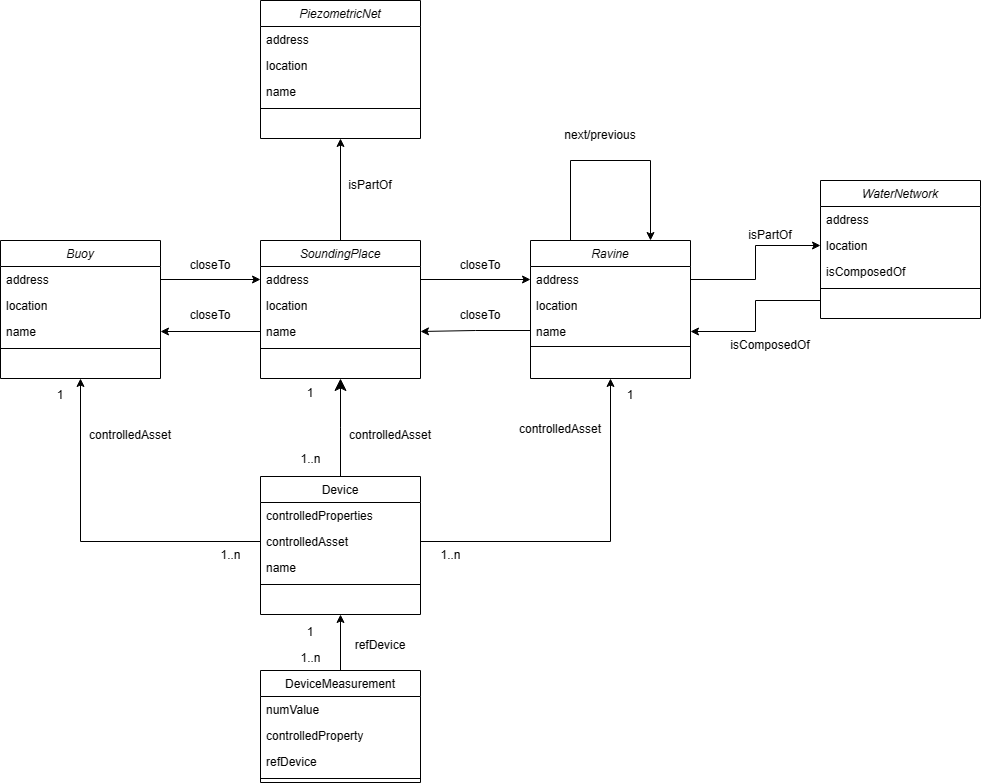

En este podemos ver varias entidades que no estan descritas en *Smart Data Models*, sino que las hemos definido nosotros. Antes de crear un nuevo modelo de NGSI-LD hay que:

1. Buscar en Smart Data Models si el modelo que estamos buscando crear existe. https://smartdatamodels.org/index.php/ddbb-of-properties-descriptions/
2. Buscar si existe la ontología en otras paginas que se encargan de ayudar a la interoperabilidad definiendo entidades y sus propiedades, como es el caso de https://schema.org/.
3. Si no existe ningún punto de partida para crear nuestro modelo cogeremos los atributos basicos que podemos ver en las entidades de Smart Data Models y le añadiremos aquellos que necesitemos, siempre intentando emplear propiedades ya existentes y descritas nuevamente en *Smart Data Models*, en *Schema.org* etc. de tal forma que sean identificables a traves de una URL, como es el caso de *controlledProperty*, que la podemos encontrar descrita bajo esta URL: https://smartdatamodels.org/dataModel.Device/controlledProperty

## Donde esta definido el esquema?

El esquema esta definido en mi github en un repositorio publico (https://github.com/mariete1223/MarMenor), ya que el contexto debe estar accesible y referenciable a traves de una URL, en este encontramos las entidades modeladas con sus propiedades correspondientes en archivos .yaml y dentro cada uno de su propia carpeta. El contexto es generado a partir del fichero marMenor.yaml que se encarga de recopilar las distintas entidades empleadas en nuestro modelado del Mar Menor.

En caso de querer añadir una nueva entidad habría que incluirla en este fichero, ya sea una existente o no existente en Smart Data Models.

Para generar el contexto a partir del .yaml se ha empleado la herramienta que se nos proporciona en uno de los tutoriales de la página de FIWARE, en esta URL https://ngsi-ld-tutorials.readthedocs.io/en/latest/understanding-%40context.html

Toda nueva property que se añada a cualquier .yaml tiene que tener el metadato uri-prefix que lleve al lugar en el que podemos encontrar la definición de esa propiedad o entidad

## Como se introducen los datos 

Los datos de las mediciones de los distintos dispositivos se encuentran en ficheros .csv, que es la única información con la que contamos. Por ello toda la información estática de las entidades como la descripción, nombre, localización etcétera se han definido manualmente en diccionarios que podemos observar en el fichero donde se suben los datos , *script_start_up_new_version*. 

A la hora de querer incluir una nueva instancia de una entidad, como por ejemplo una Boya habría que:

- Consultar si todas las propiedades medidas estan en la propiedad *controlledProperties* de *Device*, que esta definido en el archivo *marMenor.yaml*.
- Si no esta añadirla
- Modificar los diccionarios de *script_start_up_new_version* para añadir la información de la nueva propiedad.

**En caso de tener una estructura completamente distina serán necesarias otras modificaciones, por ejemplo, en las boyas se espera que haya mediciones a distintas profundidades, con una estructura concreta en las columnas del CSV, por lo que si no se cumple habría que cambiar partes del script**


## Arquitectura Docker

La arquitectura esta formada por:

**Orion Context Broker**: Guarda en formato NGSI-LD la información **actual** de las distintas entidades que tengamos.

**MongoDB**: Lugar en el que se almacenan los datos del Orion Context Broker

**Mintaka**: Encargado de almacenar los datos históricos. De forma automatica al cambiar las entidades del Orion Context Broker almacenará en su base de datos asociada los datos modidificados junto a un TimeStamp.

**TimeScale-DB**: Base de datos de series temporales donde Mintaka almacenará los datos **historicos** de nuestras entidades.



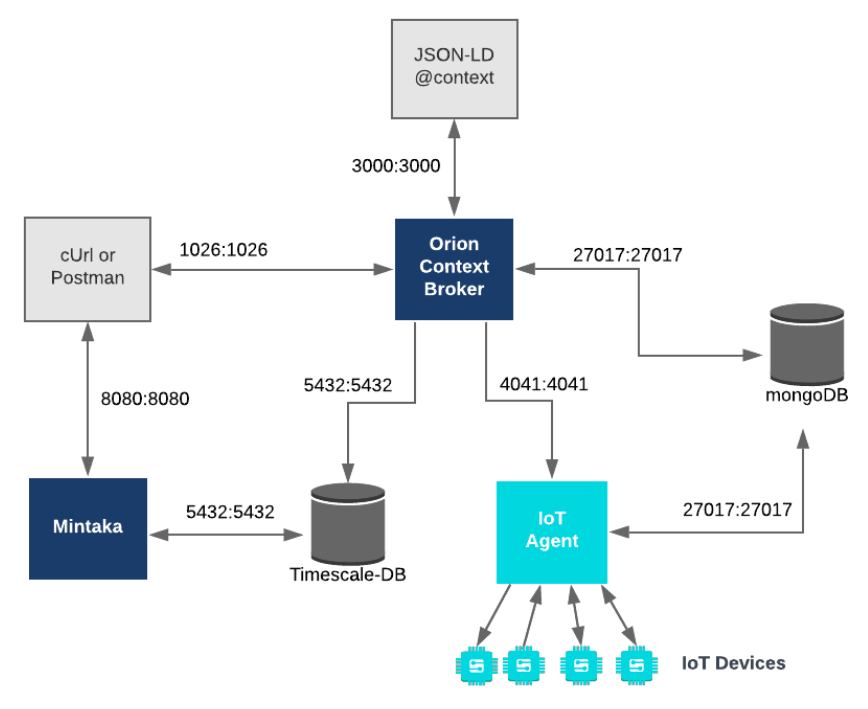

# Ejemplos de uso de el entorno conformado por Orion, Node Express y MongoDB

Se va a mostrar algunos ejemplos de las distintas consultas disponibles en el entorno desarrollado. Estos ejemplos se realizarán haciendo uso de la herramienta CURL, para poder realizar peticiones HTTP.

## ORION


En este componente encontramos los datos actuales de las distintas entidades, siguiendo el formato NGSI-LD.

En cuanto a Orion, este componente nos ofrece una gran diversidad de operaciones, consultas, filtrado etcétera. A continuación se mostrarán algunas de las operaciones empleadas para la creación del entorno basado en el Mar Menor para poder crear, modificar, recuperar y eliminar entidades, asi como, la posibilidad de realizar consultas aplicando distintos filtros, creación, modificación y eliminación de subscripciones que nos permiten monitorizar distintas entidades y atributos y poder notificar eventos relevantes, etcétera.

### Operaciones de uso frecuente

A continuación se van a mostrar operaciones de uso frecuente en la aplicación

#### Recuperar los DeviceMeasurement de una entidad

Esto se realizará en varios pasos, primero obtenemos el Device asociado:

In [19]:
%%bash
curl -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/?type=Device&q=controlledAsset==%22urn:ngsi-ld:Buoy:001%22' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-H 'Accept: application/json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1090  100  1090    0     0   154k      0 --:--:-- --:--:-- --:--:--  177k


HTTP/1.1 200 OK
Date: Wed, 20 Mar 2024 09:54:51 GMT
Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"
Content-Type: application/json
Content-Length: 1090

[{"id":"urn:ngsi-ld:Device:001","type":"Device","alternateName":{"type":"Property","value":"Device001 for Buoy 001"},"areaServed":{"type":"Property","value":"Mar Menor"},"controlledAsset":{"type":"Relationship","object":["urn:ngsi-ld:Buoy:001"]},"controlledProperty":{"type":"Property","value":["oxygen","transparency","salinity","pH","conductivity","polyethylene","chlorophyll","temperature","OrganicMatterSensor","turbidity"]},"dateLastValueReported":{"type":"Property","value":"2023-08-24T00:00:00Z"},"description":{"type":"Property","value":"Buoy E12 for measuring water quality in Mar Menor"},"deviceCategory":{"type":"Property","value":"sensor"},"address":{"type":"Property","value":{"addressCo

Luego obtenemos los Device Measurements asociados a ese dispositivo

In [2]:
%%bash
curl -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/?type=DeviceMeasurement&q=refDevice==%22urn:ngsi-ld:Device:001%22' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-H 'Accept: application/json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


HTTP/1.1 200 OK
Date: Tue, 19 Mar 2024 12:39:35 GMT
Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"
Content-Type: application/json
Content-Length: 12182



100 12182  100 12182    0     0   586k      0 --:--:-- --:--:-- --:--:--  594k


[{"id":"urn:ngsi-ld:DeviceMeasurement:210","type":"DeviceMeasurement","deviceType":{"type":"Property","value":"OxygenSensor"},"controlledProperty":{"type":"Property","value":"oxygen"},"dateLastValueReported":{"type":"Property","value":"2023-08-24T00:00:00Z"},"numValue":{"type":"Property","value":5.53,"observedAt":"2023-08-24T00:00:00.000Z"},"refDevice":{"type":"Relationship","object":"urn:ngsi-ld:Device:001"},"source":{"type":"Property","value":"https://idearm.imida.es/cgi/siomctdmarmenor/#CTD-E12"},"name":{"type":"Property","value":"DeviceMeasurement 210"},"depth":{"type":"Property","value":0}},{"id":"urn:ngsi-ld:DeviceMeasurement:211","type":"DeviceMeasurement","deviceType":{"type":"Property","value":"OxygenSensor"},"controlledProperty":{"type":"Property","value":"oxygen"},"dateLastValueReported":{"type":"Property","value":"2023-08-24T00:00:00Z"},"numValue":{"type":"Property","value":5.52,"observedAt":"2023-08-24T00:00:00.000Z"},"refDevice":{"type":"Relationship","object":"urn:ngsi-l

Podemos incluir filtros para encontrar los Device Measurements que necesitemos, por ejemplo si queremos los DeviceMeasurements de la propiedad **temperature** a una profundidad de 0 lo haríamos de la siguiente forma:

In [3]:
%%bash
curl -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/?type=DeviceMeasurement&q=refDevice==%22urn:ngsi-ld:Device:001%22;controlledProperty==%22temperature%22;depth==0' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-H 'Accept: application/json' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   672  100   672    0     0  71512      0 --:--:-- --:--:-- --:--:-- 74666


HTTP/1.1 200 OK
Date: Tue, 19 Mar 2024 12:39:43 GMT
Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"
Content-Type: application/json
Content-Length: 672

[{"id":"urn:ngsi-ld:DeviceMeasurement:287","type":"DeviceMeasurement","deviceType":{"type":"Property","value":"TemperatureSensor"},"controlledProperty":{"type":"Property","value":"temperature"},"dateLastValueReported":{"type":"Property","value":"2023-08-24T00:00:00Z"},"numValue":{"type":"Property","value":30.64,"observedAt":"2023-08-24T00:00:00.000Z","unitCode":"CEL"},"refDevice":{"type":"Relationship","object":"urn:ngsi-ld:Device:001"},"source":{"type":"Property","value":"https://idearm.imida.es/cgi/siomctdmarmenor/#CTD-E12"},"name":{"type":"Property","value":"DeviceMeasurement 287"},"unit":{"type":"Property","value":"CEL"},"depth":{"type":"Property","value":0}}]

### CRUD Entidades

Encontramos 4 operaciones basicas:

#### Creación

En este apartado mostraremos la creción de un par de entidades que encontramos en el entorno del Mar Menor, Rambla(Ravine) y 

##### Creación de una Rambla

In [ ]:
%%bash

curl -iX POST 'http://localhost:1026/ngsi-ld/v1/entities/' \
-H 'Content-Type: application/ld+json' \
--data-raw '{
        "id": f"urn:ngsi-ld:Ravine:001",
        "identifier":{
            "type": "Property",
            "value": f"Ravine:001"
        },
        "type": "Ravine",
        "description": {
            "type": "Property",
            "value": "Río Guadalentín paretón de Totana"
        },
        "address": {
            "type": "Property",
            "value": {
            "addressCountry": "ES",
            "addressRegion": "Murcia",
            "addressLocality": "Totana",
            "postalCode": "30850"
            },
            "verified": {
                "type": "Property",
                "value": True
            }
        },
        "source": {
            "type": "Property",
            "value": "https://saihweb.chsegura.es/apps/iVisor/"
        },
        "location": {
        "type": "GeoProperty",
        "value": {
            "type": "Point",
            "coordinates": [
                37.721387,
                -1.495578
            ]
        }
        },
        "name": {
        "type": "Property",
        "value": "Paretón Totana"
        },
        "@context": "https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"
    }'

##### Creación de una Boya

In [ ]:
%%bash

curl -iX POST 'http://localhost:1026/ngsi-ld/v1/entities/' \
-H 'Content-Type: application/ld+json' \
--data-raw '{
    "id": "urn:ngsi-ld:Buoy:sea001",
    "identifier": {
        "type": "Property",
        "value": "urn:ngsi-ld:Buoy:sea001"
    },
    "type": "Buoy",
    "description": {
        "type": "Property",
        "value": "Boya del Mar Menor zona de Lo Pagan"
    },
    "address": {
        "type": "Property",
        "value": {
            "addressCountry": "ES",
            "addressRegion": "Murcia",
            "addressLocality": "Murcia",
            "postalCode": "30009"
        },
        "verified": {
            "type": "Property",
            "value": true
        }
    },
    "source":
    {
        "type": "Property",
        "value": "https://idearm.imida.es/cgi/siomctdmarmenor/"
    },
    "location": {
        "type": "GeoProperty",
        "value": {
             "type": "Point",
             "coordinates": [37.81, -0.78]
        }
    },
    "name": {
        "type": "Property",
        "value": "CTD-E1"
    },
    "@context": "https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"
}'

#### Modificación

En este apartado mostraremos un par de operaciones basicas, que son las que han sido empleadas para modificar los datos a la hora de incluir los valores historicos.

##### Modificar el valor del campo de una entidad

En este caso indicamos que queremos que se modifique el valor del atributo *temperature* de la entidad **TemperatureSenor** a 100, pudiendo añadirle los metadatos desados tambien, en este caso se indica que la fecha en la que se recogío ese dato fue en *2023-11-12T11:09:27.460Z*.

In [ ]:
%%bash

curl -iX PATCH 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:TemperatureSensor:000/attrs/temperature' \
-H 'Content-Type: application/json' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
--data-raw '{
    "value": 100,
    "observedAt": "2023-11-12T11:09:27.460Z"
}'

##### Modificar multiples campos de una entidad simultaneamente

En este caso modificamos dos atributos, temperatura y el objecto que controla el sensor

In [ ]:
%%bash

curl -iX PATCH 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:TemperatureSensor:001/attrs' \
-H 'Content-Type: application/json' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
--data-raw '{
      "temperature": {
            "value": 100,
            "observedAt": "2023-11-12T11:09:27.460Z"
       },
      "controlledAsset": {
            "type": "Relationship",
            "object": "urn:ngsi-ld:Ravine:001"
      }
}'

#### Recuperar

En este apartado se mostrará la forma de recuperar las distintas entidades que encontramos en Orion, tanto una unica entidad como todas ellas, atributos concretos, etcétera.

##### Recuperar todas las boyas

In [4]:
%%bash
curl -G -X GET \
  'http://localhost:1026/ngsi-ld/v1/entities' \
  -H 'Accept: application/ld+json' \
  -d 'type=https://raw.githubusercontent.com/mariete1223/MarMenor/main/Buoy/buoy.yaml%23/Buoy'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10131  100 10131    0     0  1389k      0 --:--:-- --:--:-- --:--:-- 1648k


[{"@context":"https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context-v1.6.jsonld","id":"urn:ngsi-ld:Buoy:000","type":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/Buoy/buoy.yaml#/Buoy","https://smartdatamodels.org/identifier":{"type":"Property","value":"Buoy:000"},"description":{"type":"Property","value":"Buoy E3 for measuring water quality in the Mar Menor"},"https://smartdatamodels.org/address":{"type":"Property","value":{"addressCountry":"ES","addressRegion":"Murcia","addressLocality":"Mar Menor, Playa de la Hita, Cartagena","postalCode":"30380"}},"location":{"type":"GeoProperty","value":{"type":"Point","coordinates":[37.76,-0.78]}},"https://smartdatamodels.org/name":{"type":"Property","value":"Buoy E3"},"https://smartdatamodels.org/source":{"type":"Property","value":"https://idearm.imida.es/cgi/siomctdmarmenor/#CTD-E3"}},{"@context":"https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context-v1.6.jsonld","id":"urn:ngsi-ld:Buoy:001","type":"https://raw.githubusercontent.com/m

##### Recuperar todas las ramblas

In [7]:
%%bash
curl -G -X GET   'http://localhost:1026/ngsi-ld/v1/entities'   \
 -H 'Accept: application/ld+json'   \
 -d 'type=https://raw.githubusercontent.com/mariete1223/MarMenor/main/Ravine/ravine.yaml%23/Ravine'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15900  100 15900    0     0  2648k      0 --:--:-- --:--:-- --:--:-- 3105k


[{"@context":"https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context-v1.6.jsonld","id":"urn:ngsi-ld:Ravine:002","type":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/Ravine/ravine.yaml#/Ravine","https://smartdatamodels.org/identifier":{"type":"Property","value":"Ravine:002"},"description":{"type":"Property","value":"Control frame 06A02 in Pozo Estrecho, Albuj\\u00f3n watercourse."},"https://smartdatamodels.org/address":{"type":"Property","value":{"addressCountry":"ES","addressRegion":"Murcia","addressLocality":"Pozo Estrecho, Cartagena","postalCode":"30594"},"verified":{"type":"Property","value":true}},"https://smartdatamodels.org/source":{"type":"Property","value":"https://saihweb.chsegura.es/apps/iVisor/visor_variable.php?punto=06A02U12"},"location":{"type":"GeoProperty","value":{"type":"Point","coordinates":[37.7239,-0.9793]}},"https://smartdatamodels.org/name":{"type":"Property","value":"Ravine 06A02"},"https://raw.githubusercontent.com/mariete1223/MarMenor/main/Ravine/

##### Recuperar todas los sondeos piezometricos

In [72]:
%%bash
curl -G -X GET http://localhost:1026/ngsi-ld/ex/v1/tenants
 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     2  100     2    0     0   1826      0 --:--:-- --:--:-- --:--:--  2000


[]

In [61]:
%%bash
curl -G -X GET \
  'http://localhost:8080/ngsi-ld/v1/temporal/entities' \
  -H 'Accept: application/ld+json' \


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   154  100   154    0     0     93      0  0:00:01  0:00:01 --:--:--    92


{"message":"Not Found","logref":{"empty":true,"present":false},"path":{"empty":true,"present":false},"_links":{"empty":false},"_embedded":{"empty":false}}

In [45]:
%%bash
curl -G -X GET \
  'http://localhost:1026/ngsi-ld/v1/entities' \
  -H 'Accept: application/ld+json' \
  -H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
  -H 'Accept: application/json' \
  -d 'type=SoundingPlace'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


100   231  100   231    0     0   1018      0 --:--:-- --:--:-- --:--:--  1017


{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Recuperar una entidad por su identificador

In [46]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:Ravine:012' -H 'Accept: application/ld+json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1206  100  1206    0     0   541k      0 --:--:-- --:--:-- --:--:-- 1177k


HTTP/1.1 200 OK
Date: Wed, 12 Jun 2024 10:59:50 GMT
Content-Type: application/ld+json
Content-Length: 1206

{"@context":"https://uri.etsi.org/ngsi-ld/v1/ngsi-ld-core-context-v1.6.jsonld","id":"urn:ngsi-ld:Ravine:012","type":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/Ravine/ravine.yaml#/Ravine","https://smartdatamodels.org/identifier":{"type":"Property","value":"Ravine:012"},"description":{"type":"Property","value":"Meteorological-Hydrological Station 01M02 el Relojero (AMETSE)"},"https://smartdatamodels.org/address":{"type":"Property","value":{"addressCountry":"ES","addressRegion":"Murcia","addressLocality":"El Relojero, La Alberca, Murcia","postalCode":"30155"},"verified":{"type":"Property","value":true}},"https://smartdatamodels.org/source":{"type":"Property","value":"https://saihweb.chsegura.es/apps/iVisor/visor_variable.php?punto=01M02P01"},"location":{"type":"GeoProperty","value":{"type":"Point","coordinates":[37.9136,-1.119]}},"https://smartdatamodels.org/name":

In [78]:
%%bash
curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   166  100   166    0     0    104      0  0:00:01  0:00:01 --:--:--   104


{"message":"Internal Server Error","logref":{"empty":true,"present":false},"path":{"empty":true,"present":false},"_links":{"empty":false},"_embedded":{"empty":false}}

##### Recuperar un atributo de una entidad (temperatura en este caso)

In [47]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:Ravine:012' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-d 'attrs=temperature'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   231  100   231    0     0   1113      0 --:--:-- --:--:-- --:--:--  1115


HTTP/1.1 503 Service Unavailable
Date: Wed, 12 Jun 2024 10:59:50 GMT
Content-Type: application/json
Content-Length: 231

{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Recuperar varios atributos de una entidad 

In [48]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:Ravine:012' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-d 'attrs=precipitation,temperature'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


100   231  100   231    0     0    961      0 --:--:-- --:--:-- --:--:--   962


HTTP/1.1 503 Service Unavailable
Date: Wed, 12 Jun 2024 10:59:50 GMT
Content-Type: application/json
Content-Length: 231

{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Realizar busquedas a traves de coordenadas geográficas

In [85]:
!curl -G -X GET 'http://localhost:1026/ngsi-ld/v1/entities' \
  -H 'Link: <https://raw.githubusercontent.com/yuye188/MarMenorDT/main/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
  -H 'Accept: application/json' \
  -d 'type=Device' \
  -d 'geometry=Point' \
  -d 'coordinates=[37.7544,-0.8586]' \
  -d 'georel=near;maxDistance==1000' \
  -d 'options=keyValues' | python -c 'import sys, json; result = json.dumps(json.load(sys.stdin), indent=4); print(result)'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   783  100   783    0     0   241k      0 --:--:-- --:--:-- --:--:--  382k
[
    {
        "id": "urn:ngsi-ld:Device:015",
        "type": "Device",
        "alternateName": "Multiple sensors for Sounding Place 06Z11",
        "areaServed": "Mar Menor",
        "controlledAsset": [
            "urn:ngsi-ld:SoundingPlace:003"
        ],
        "controlledProperty": [
            "tds",
            "conductivity",
            "piezometricLevel",
            "salinity",
            "temperature"
        ],
        "dateLastValueReported": "2024-06-02T23:55:00Z",
        "description": "Device from Piezometric Net, belonging to the Sounding Place 06Z11",
        "deviceCategory": "sensor",
        "address": {
            "addressCountry": "ES",
            "addressRegion": "Murcia",
            "addressLocality": "Avenida de Mu\

In [50]:
%%bash
curl -G -X GET \
  'http://localhost:1026/ngsi-ld/v1/entities' \
  -H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
  -H 'Accept: application/json' \
  -d 'geometry=Point' \
  -d 'coordinates=%5B37.7544,-0.8586%5D' \
  -d 'georel=near%3BmaxDistance==5000' \
  -d 'options=keyValues'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   231  100   231    0     0    968      0 --:--:-- --:--:-- --:--:--   966


{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Realizar filtro por algun campo

In [51]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-H 'Accept: application/json' \
-d 'id=urn:ngsi-ld:TemperatureSensor:001,urn:ngsi-ld:TemperatureSensor:002' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   231  100   231    0     0   1194      0 --:--:-- --:--:-- --:--:--  1196


HTTP/1.1 503 Service Unavailable
Date: Wed, 12 Jun 2024 10:59:51 GMT
Content-Type: application/json
Content-Length: 231

{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Formas de recuperar los datos

Hay varias formas de recuperar los datos:

* Verbose: nos proporciona todos los metadatos a parte de los valores (por defecto)
* KeyValue: nos proporciona solo clave valore, suprimiendo los metadatos

Como Verbose es por defecto, mostraremos como se haría con **KeyValue**:

In [52]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:Ravine:012' \
    -H 'Accept: application/ld+json' \
    -H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
    -d 'options=keyValues'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   231  100   231    0     0   1071      0 --:--:-- --:--:-- --:--:--  1074


HTTP/1.1 503 Service Unavailable
Date: Wed, 12 Jun 2024 10:59:51 GMT
Content-Type: application/json
Content-Length: 231

{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

#### Eliminar

En este apratado mostraremos un par de ejemplos para eliminar entidades existentes

##### Eliminar un sensor

In [53]:
%%bash
curl -iX DELETE 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:TemperatureSensor:004'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   135  100   135    0     0  83487      0 --:--:-- --:--:-- --:--:--  131k


HTTP/1.1 404 Not Found
Date: Wed, 12 Jun 2024 10:59:51 GMT
Content-Type: application/json
Content-Length: 135

{"type":"https://uri.etsi.org/ngsi-ld/errors/ResourceNotFound","title":"Entity not found","detail":"urn:ngsi-ld:TemperatureSensor:004"}

##### Eliminar una rambla

In [54]:
%%bash
curl -iX DELETE 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:Ravine:004'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


HTTP/1.1 204 No Content
Date: Wed, 12 Jun 2024 10:59:51 GMT



### CRUD Subscripciones

Las subscripciones son un mecanismo de gran utilidad que nos permite enviar notificaciones a un endpoint definido por nosotros para indicar la ocurrencia de algun evento que requiere supervisión o una acción como consecuencia. 

#### Creación

Vamos a mostrar algún ejemplo de creación de subscripciones indicando su gran versatilidad

##### Creación de una subscripción para monitorizar cambios de temperatura

En este caso hemos creado una subscripcion con lo siguiente:

* El atributo a observar (*watchedAttributes*) es la temperatura
* Se esta monitorizando la entidades de tipo *Ravine*
* Para enviar la notificación debe haber cambiado la temperatura a un valor entre 10 y 100
* Los datos de la entidad que queremos enviar son: *temperature*
* El endpoint al que queremos notificar el evento es a *http://node-app:3000/historic* (Nuestro node express)

In [55]:
%%bash

curl -L -X POST 'http://localhost:1026/ngsi-ld/v1/subscriptions/' \
-H 'Content-Type: application/ld+json' \
--data-raw '{
  "description": "Una prueba de notificacion, ante un cambio de temperatura",
  "type": "Subscription",
  "entities": [{"type": "Ravine"}],
  "watchedAttributes": ["temperature"],
  "q": "temperature>10;temperature<100",
  "notification": {
    "attributes": ["temperature"],
    "format": "normalized",
    "endpoint": {
      "uri": "http://node-app:3000/historic/a",
      "accept": "application/json"
    }
  },
   "@context": "https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"
}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   782  100   231  100   551   1073   2560 --:--:-- --:--:-- --:--:--  3637


{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

##### Creación de una subscripción mas restrictiva

En este caso, estamos creando una subscripción para un Sensor en especifico, restringiendolo a traves de el filtro *q*, en el que hemos indicado que sea la entidad que concuerde con un atributo source concreto y que la propiedad que este controlando sea la temperatura.

Ademas, hemos indicado que queremos enviar mas atributos que los monitorizados a nuestro endpoin.

In [56]:
%%bash
curl -L -X POST 'http://localhost:1026/ngsi-ld/v1/subscriptions/' \
-H 'Content-Type: application/ld+json' \
--data-raw '{
    "description": "Subscription to get info about urn:ngsi-ld:PiezometricPoint:000 sensor", 
    "type": "Subscription", "entities": [{"type": "TemperatureSensor"}], 
    "watchedAttributes": ["temperature"], 
    "q": "source==%22https://saihweb.chsegura.es/apps/iVisor/visor_variable.php?punto=06Z01E10%22;controlledProperty==%22temperature%22",
    "notification": {
        "attributes": ["temperature", "controlledAsset", "measureType"], 
        "format": "normalized", 
        "endpoint": {"uri": "http://node-app:3000/historic/urn:ngsi-ld:TemperatureSensor:000", 
        "accept": "application/json"
        }
    }, 
    "@context": "https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"
}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   996  100   231  100   765   1090   3610 --:--:-- --:--:-- --:--:--  4698


{"type":"https://uri.etsi.org/ngsi-ld/errors/LdContextNotAvailable","title":"Unable to download context","detail":"https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld"}

#### Eliminación

In [57]:
%%bash
curl -X DELETE \
  --url 'http://localhost:1026/ngsi-ld/v1/subscriptions/urn:ngsi-ld:Subscription:5fd228838b9b83697b855a72'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   157  100   157    0     0   104k      0 --:--:-- --:--:-- --:--:--  153k


{"type":"https://uri.etsi.org/ngsi-ld/errors/ResourceNotFound","title":"Subscription not found","detail":"urn:ngsi-ld:Subscription:5fd228838b9b83697b855a72"}

#### Recuperación

##### Recuperación de todas las subscripciones

In [58]:
%%bash
curl -X GET \
  --url 'http://localhost:1026/ngsi-ld/v1/subscriptions/

bash: line 2: unexpected EOF while looking for matching `''
bash: line 3: syntax error: unexpected end of file


CalledProcessError: Command 'b"curl -X GET \\\n  --url 'http://localhost:1026/ngsi-ld/v1/subscriptions/\n"' returned non-zero exit status 2.

##### Recuperación de una subscripcion

In [ ]:
%%bash
curl -X GET \
  --url 'http://localhost:1026/ngsi-ld/v1/subscriptions/urn:ngsi-ld:Subscription:5fd228838b9b83697b855a72'

## MINTAKA y TIMESCALE-DB


Se ha sustituido el MongoDB por un componente ya desarrollado y que cuenta con integración con ORION y NGSI-LD que nos proporciona una forma eficiente de almacenamiento de una base de datos temporal.

Nos ofrece las siguientes funcionalidades:

### Recuperación de datos históricos de una entidad

Indicando el ID de una de las entidades de nuestro ORION seremos capaces de obtener los datos, pudiendo filtrar y limitar la cantidad de datos requeridos.

#### Recuperación de los ultimos 10 datos de una entidad

%%bash

curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' 

Salida obtenida

In [ ]:
{
    "id": "urn:ngsi-ld:DeviceMeasurement:070",
    "type": "DeviceMeasurement",
    "numValue": [
        {
            "type": "Property",
            "value": 7.27,
            "observedAt": "2023-08-24T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:instance:f9c862d0-d9ae-11ee-aebc-0242ac120105",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.29,
            "observedAt": "2023-08-17T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:e6f74014-5e7b-49fe-ae20-f78eba618fc8",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.12,
            "observedAt": "2023-08-10T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:1af80b77-e25c-444e-a23c-9ecce6c08ed8",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.27,
            "observedAt": "2023-08-01T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:a9c91ce0-f755-4c3b-9b84-f77a3c8cc683",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.17,
            "observedAt": "2023-07-26T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:1721ab98-4a79-4dcb-bec1-ea440ef9c3ca",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.22,
            "observedAt": "2023-07-19T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:60bf81de-7b58-4cbc-83a1-8074fa3c9d97",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.16,
            "observedAt": "2023-07-12T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:cdade3bb-2182-45b7-91a3-72150b61a6b2",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 7.01,
            "observedAt": "2023-07-05T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:ebee4a55-e096-49ad-9c91-cc007dec656b",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 6.85,
            "observedAt": "2023-06-28T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:faf8500d-8063-4b5a-b332-f844672c8c16",
            "unitCode": "microseconds/cm"
        },
        {
            "type": "Property",
            "value": 6.65,
            "observedAt": "2023-06-21T00:00:00Z",
            "instanceId": "urn:ngsi-ld:attribute:b96ee704-67c3-43b4-a450-c34eab9724db",
            "unitCode": "microseconds/cm"
        }
    ]
}

#### Recuperación en un formato simplificado

In [ ]:
%%bash

curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' \
-d 'options=temporalValues'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   411  100   411    0     0   6489      0 --:--:-- --:--:-- --:--:--  6523


{"id":"urn:ngsi-ld:DeviceMeasurement:070","type":"DeviceMeasurement","numValue":{"type":"Property","values":[[8.61,"2023-08-24T00:00:00Z"],[8.62,"2023-08-17T00:00:00Z"],[8.65,"2023-08-10T00:00:00Z"],[8.73,"2023-08-01T00:00:00Z"],[8.66,"2023-07-26T00:00:00Z"],[8.73,"2023-07-19T00:00:00Z"],[8.71,"2023-07-12T00:00:00Z"],[8.71,"2023-07-05T00:00:00Z"],[8.73,"2023-06-28T00:00:00Z"],[8.71,"2023-06-21T00:00:00Z"]]}}

Resultado obtenido

In [ ]:
{
    "id": "urn:ngsi-ld:DeviceMeasurement:070",
    "type": "DeviceMeasurement",
    "numValue": {
        "type": "Property",
        "values": [
            [
                7.27,
                "2023-08-24T00:00:00Z"
            ],
            [
                7.29,
                "2023-08-17T00:00:00Z"
            ],
            [
                7.12,
                "2023-08-10T00:00:00Z"
            ],
            [
                7.27,
                "2023-08-01T00:00:00Z"
            ],
            [
                7.17,
                "2023-07-26T00:00:00Z"
            ],
            [
                7.22,
                "2023-07-19T00:00:00Z"
            ],
            [
                7.16,
                "2023-07-12T00:00:00Z"
            ],
            [
                7.01,
                "2023-07-05T00:00:00Z"
            ],
            [
                6.85,
                "2023-06-28T00:00:00Z"
            ],
            [
                6.65,
                "2023-06-21T00:00:00Z"
            ]
        ]
    }
}

#### Recuperación de los N datos historicos antes o despues de una fecha

In [ ]:
%%bash
curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' \
-d 'timerel=before' \
-d 'timeAt=2023-06-21T00:00:00Z'

In [ ]:
%%bash
curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' \
-d 'timerel=after' \
-d 'timeAt=2023-06-21T00:00:00Z'

#### Recuperación de los datos entre dos fechas

In [ ]:
%%bash
curl -G -X GET 'http://localhost:8080/temporal/entities/urn:ngsi-ld:DeviceMeasurement:070' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; \ type="application/ld+json"' \
-d 'lastN=10' \
-d 'timerel=between' \
-d 'timeAt=2023-06-21T00:00:00Z' \
-d 'endTimeAt=2024-03-08T10:57:56Z'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1522  100  1522    0     0    686      0  0:00:02  0:00:02 --:--:--   686


{"id":"urn:ngsi-ld:DeviceMeasurement:070","type":"DeviceMeasurement","numValue":[{"type":"Property","value":8.61,"observedAt":"2023-08-24T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:instance:8ddd5cac-e583-11ee-9ea1-0242ac120105","unitCode":"pH"},{"type":"Property","value":8.62,"observedAt":"2023-08-17T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:fde03a8d-5b99-4475-accf-6ee914dc0686","unitCode":"pH"},{"type":"Property","value":8.65,"observedAt":"2023-08-10T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:0ba13748-ff7b-4e14-9ea3-696abe554779","unitCode":"pH"},{"type":"Property","value":8.73,"observedAt":"2023-08-01T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:f1cc0da7-a9a9-41c2-b2b0-46f5e442f1d8","unitCode":"pH"},{"type":"Property","value":8.66,"observedAt":"2023-07-26T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:75ad7690-e4d0-453c-9b3e-1b069c834194","unitCode":"pH"},{"type":"Property","value":8.73,"observedAt":"2023-07-19T00:00:00Z","instanceId":"urn:ngsi-ld:attribute:c470bea9-96

In [ ]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:DeviceMeasurement:001' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-d 'attrs=numValue'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153  100   153    0     0  66783      0 --:--:-- --:--:-- --:--:-- 76500


HTTP/1.1 200 OK
Date: Tue, 19 Mar 2024 18:31:46 GMT
Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"
Content-Type: application/json
Content-Length: 153

{"id":"urn:ngsi-ld:DeviceMeasurement:001","type":"DeviceMeasurement","numValue":{"type":"Property","value":5.42,"observedAt":"2023-08-24T00:00:00.000Z"}}

In [ ]:
%%bash
curl -G -iX GET 'http://localhost:1026/ngsi-ld/v1/entities/urn:ngsi-ld:DeviceMeasurement:001' \
-H 'Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"' \
-d 'attrs=numValue,name'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   212  100   212    0     0    99k      0 --:--:-- --:--:-- --:--:--  207k


HTTP/1.1 200 OK
Date: Tue, 19 Mar 2024 18:32:21 GMT
Link: <https://raw.githubusercontent.com/mariete1223/MarMenor/main/data_models_description/datamodels.context-ngsi.jsonld>; rel="http://www.w3.org/ns/json-ld#context"; type="application/ld+json"
Content-Type: application/json
Content-Length: 212

{"id":"urn:ngsi-ld:DeviceMeasurement:001","type":"DeviceMeasurement","numValue":{"type":"Property","value":5.42,"observedAt":"2023-08-24T00:00:00.000Z"},"name":{"type":"Property","value":"DeviceMeasurement 001"}}